In [18]:
import bt
from datetime import date
import model as model
from model import Security, Exchange, DataVendor, Quotation
from database import db_session, db_engine, Base
from datetime import datetime, timedelta, date
import pandas as pd
%matplotlib inline

In [90]:
# Load data from database
df1 = Quotation.get_dataframe("BPE5.DE")
df2 = Quotation.get_dataframe("PFE")

# Change format to the one expected by bt

# Price (adj_close) equals name of security
df1.rename(columns={'adj_close':'BPE5.DE'}, inplace=True)
df2.rename(columns={'adj_close':'PFE'}, inplace=True)

# Date as index
df1.set_index("date", inplace = True)
df2.set_index("date", inplace = True)

# Drop unneeded columns
df1.drop(columns = ["id", "open", "high", "low", "close", "volume", "created_date", "last_updated", "data_vendor_id", "security_id"], axis = 1, inplace = True)
df2.drop(columns = ["id", "open", "high", "low", "close", "volume", "created_date", "last_updated", "data_vendor_id", "security_id"], axis = 1, inplace = True)

C:\Users\Fabian\Anaconda3\lib\site-packages\sqlalchemy\sql\sqltypes.py:562: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


In [95]:
data = pd.merge_ordered(df1, df2, on = "date", how = "outer")
data.set_index("date", inplace = True)

In [96]:
data.tail()

,BPE5.DE,PFE
date,,
2020-01-13,5.80,39.41
2020-01-14,5.80,40.07
2020-01-15,5.79,40.67
2020-01-16,5.82,40.61
2020-01-17,5.83,40.51


In [112]:
data = data.interpolate()

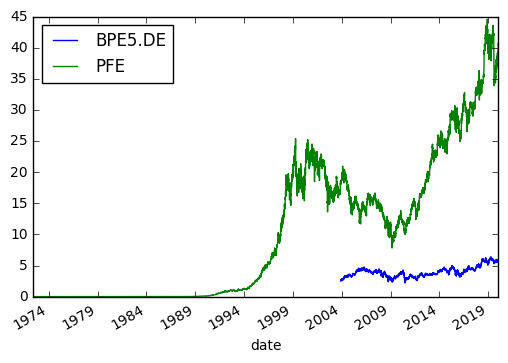

In [113]:
data.plot()

In [116]:
# create the strategy
s1 = bt.Strategy('s1', [bt.algos.RunAfterDate(date(2016,1,1)),
                        bt.algos.RunWeekly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

test_s1 = bt.Backtest(s1, data, initial_capital = 100000)

# Create a second strategy - long only
s_long = bt.Strategy('long', [bt.algos.RunAfterDate(date(2005,1,1)),bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighEqually(),bt.algos.Rebalance()])

test_s_long = bt.Backtest(s_long, data, initial_capital=100000)

In [117]:
# create a backtest and run it
res = bt.run(test_s1, test_s_long)

s1
0% [############################# ] 100% | ETA: 00:00:00

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

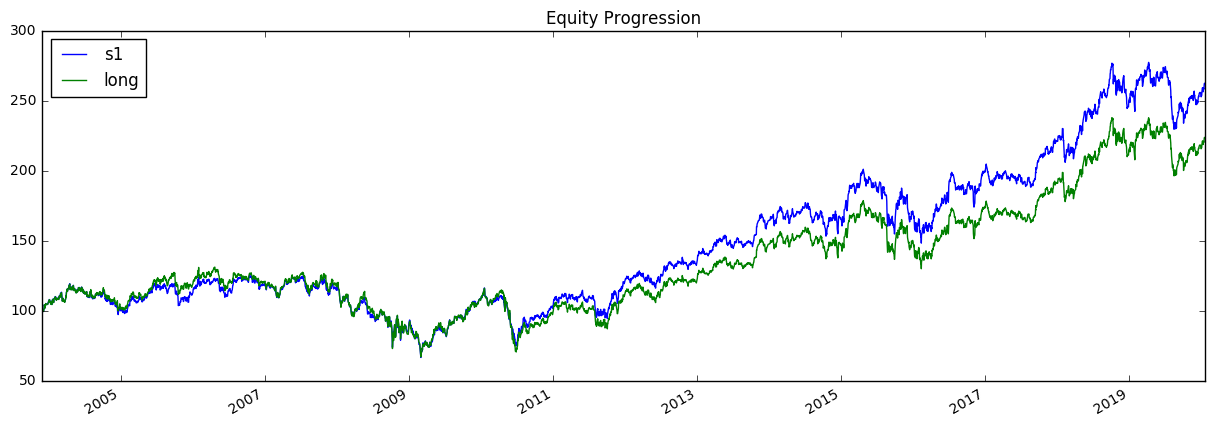

In [41]:
res.plot()

In [44]:
res.display_lookback_returns()

,long,s1
mtd,3.72%,3.79%
3m,7.97%,8.24%
6m,-0.34%,-0.08%
ytd,3.72%,3.79%
1y,2.89%,3.52%
3y,9.45%,10.23%
5y,7.91%,8.76%
10y,6.80%,8.49%
incep,5.12%,6.16%


In [35]:
# Weekly rebalancing was slightly better than buy and hold